<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии</center>
## <center>Часть 10. Xgboost и Hyperopt в соревновании Kaggle Forest Cover Type Prediction</center>

[Соревнование](https://www.kaggle.com/c/forest-cover-type-prediction). 
Задача учебная. Предлагается предсказывать тип лесного покрытия на участках 30х30 метров Национального заповедника Рузвельта в Колорадо.

Признаки (подробней на [странице](https://www.kaggle.com/c/forest-cover-type-prediction/data) соревнования):

- Elevation (высота) - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope (наклон) - Slope in degrees
- Horizontal_Distance_To_Hydrology (горизонтальное расстояние до воды) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (вертикальное расстояние до воды) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (горизонтальное расстояние до дорог) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
- Horizontal_Distance_To_Fire_Points (горизонтальное расстояние до центров воспламенения) - Horz Dist to nearest wildfire ignition points 
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (тип почвы) - (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Подключаем библиотеки и загружаем данные. Используем [log_progress](https://github.com/alexanderkuk/log-progress) для отслеживания итераций в циклах.**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../scripts/')
from log_progress import log_progress

Populating the interactive namespace from numpy and matplotlib


**Файл forest_test.csv можно скачать [отсюда](https://yadi.sk/d/gqsbD1BLzSYvC)**

In [3]:
train_df = pd.read_csv('../../data/forest_train.csv')
test_df = pd.read_csv('../../data/forest_test.csv')

In [4]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Cover_Type', index_label="Id", init_index=15121):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(init_index, 
                                                  predicted_labels.shape[0] + init_index),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Создаем признаки.**

In [5]:
train_df['Under_water'] = train_df.Vertical_Distance_To_Hydrology < 0
test_df['Under_water'] = test_df.Vertical_Distance_To_Hydrology < 0

In [6]:
train_df['EVDtH'] = train_df.Elevation - train_df.Vertical_Distance_To_Hydrology
test_df['EVDtH'] = test_df.Elevation - test_df.Vertical_Distance_To_Hydrology

train_df['EHDtH'] = train_df.Elevation - train_df.Horizontal_Distance_To_Hydrology*0.2
test_df['EHDtH'] = test_df.Elevation - test_df.Horizontal_Distance_To_Hydrology*0.2

In [7]:
train_df['Distanse_to_Hydrolody'] = (train_df['Horizontal_Distance_To_Hydrology'] ** 2 + 
                                  train_df['Vertical_Distance_To_Hydrology']**2) ** 0.5
test_df['Distanse_to_Hydrolody'] = (test_df['Horizontal_Distance_To_Hydrology']**2 + 
                                 test_df['Vertical_Distance_To_Hydrology']**2) ** 0.5

train_df['Hydro_Fire_1'] = train_df['Horizontal_Distance_To_Hydrology'] + \
    train_df['Horizontal_Distance_To_Fire_Points']
test_df['Hydro_Fire_1'] = test_df['Horizontal_Distance_To_Hydrology'] + \
    test_df['Horizontal_Distance_To_Fire_Points']

train_df['Hydro_Fire_2'] = abs(train_df['Horizontal_Distance_To_Hydrology'] - \
                                train_df['Horizontal_Distance_To_Fire_Points'])
test_df['Hydro_Fire_2'] = abs(test_df['Horizontal_Distance_To_Hydrology'] - \
                           test_df['Horizontal_Distance_To_Fire_Points'])

train_df['Hydro_Road_1'] = abs(train_df['Horizontal_Distance_To_Hydrology'] + \
                            train_df['Horizontal_Distance_To_Roadways'])
test_df['Hydro_Road_1'] = abs(test_df['Horizontal_Distance_To_Hydrology'] + \
                           test_df['Horizontal_Distance_To_Roadways'])

train_df['Hydro_Road_2'] = abs(train_df['Horizontal_Distance_To_Hydrology'] - \
                            train_df['Horizontal_Distance_To_Roadways'])
test_df['Hydro_Road_2'] = abs(test_df['Horizontal_Distance_To_Hydrology'] - \
                           test_df['Horizontal_Distance_To_Roadways'])

train_df['Fire_Road_1'] = abs(train_df['Horizontal_Distance_To_Fire_Points'] + \
                           train_df['Horizontal_Distance_To_Roadways'])
test_df['Fire_Road_1'] = abs(test_df['Horizontal_Distance_To_Fire_Points'] + \
                          test_df['Horizontal_Distance_To_Roadways'])

train_df['Fire_Road_2'] = abs(train_df['Horizontal_Distance_To_Fire_Points'] - \
                           train_df['Horizontal_Distance_To_Roadways'])
test_df['Fire_Road_2'] = abs(test_df['Horizontal_Distance_To_Fire_Points'] - \
                          test_df['Horizontal_Distance_To_Roadways'])

In [8]:
y = train_df['Cover_Type']
train_df = train_df.drop(['Cover_Type', 'Id'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

In [9]:
y = y - 1 # Чтоб классы нумеровались от о до 6

In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [103]:
def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 7))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [104]:
def optimize(trials):
    space = {
             'n_estimators' : 150,
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 4, 10, 2),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
             'gamma' : 0,
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
             'num_class' : 7,
             'eval_metric': 'merror',
             'objective': 'multi:softprob',
             'nthread' : 4,
             'silent' : 1
             }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)

    print(best)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.2, random_state=1234)

In [ ]:
trials = Trials()
optimize(trials)

In [14]:
param = {'colsample_bytree': 0.75, 'silent': 1, 'eval_metric': 'merror', 'nthread': 4, 
         'min_child_weight': 4.0, 'n_estimators': 150, 'subsample': 0.75, 'eta': 0.175, 
         'objective': 'multi:softprob', 
         'num_class': 7, 'max_depth': 8, 'gamma': 0}

In [15]:
dtrain = xgb.DMatrix(train_df, y)

In [18]:
%%time
xgbCvResult = xgb.cv(param, dtrain, 
                      num_boost_round=250,  
                      nfold=5)

CPU times: user 11min 11s, sys: 28.8 s, total: 11min 40s
Wall time: 4min 30s


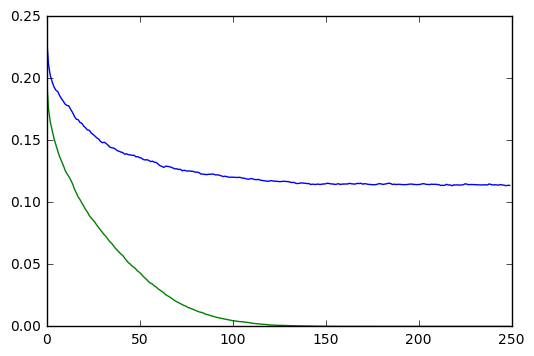

In [19]:
plot(range(xgbCvResult.shape[0]), xgbCvResult['test-merror-mean'])
plot(range(xgbCvResult.shape[0]), xgbCvResult['train-merror-mean']);

In [20]:
best_num_round = np.argmin(xgbCvResult['test-merror-mean'])

**Сделаем прогноз для всей тестовой выборки.**

In [21]:
bestXgb = xgb.train(param, dtrain, 750)

In [22]:
dtest = xgb.DMatrix(test_df)

In [23]:
xgboost_predict_proba = bestXgb.predict(dtest)

In [24]:
xgboost_prediction = np.argmax(xgboost_predict_proba,
                                         axis=1)

**Мы вычитали из целевых меток 1, теперь добавляем.**

In [25]:
xgboost_prediction += 1

In [26]:
write_to_submission_file(xgboost_prediction, 
                         '../../output/forest_cover_type_xgboost.csv')

**У такой посылки на Kaggle результат - 0.77842.**